# Tree crown detection and multi-class classification (DeepForest)

## Context
### Purpose
Detect and classify tree crowns using a pre-trained Deep Learning model.

### Modelling Approach
The [CropModel](https://deepforest.readthedocs.io/en/latest/CropModels.html) from the latest version (v1.4.0) of the [DeepForest](https://deepforest.readthedocs.io/en/latest/) Deep Learning model is used to predict bounding boxes corresponding to individual tree crowns from airborn RGB images, and then perfom multi-class classifaction on each of those detections. 

DeepForest was trained on data from the National Ecological Observatory Network (NEON), and implemented using pytorch.

### Description
This notebook will explore the performance of DeepForest's pre-trained models on different publicly available pre-processed data:

- Homogeneous vs heterogeneous landscape
- Small distinct tree-crowns vs large dense canopies
- High vs low resolution images
- Tiles vs entire images

Additionally, it will cover post-processing steps to evaluate and visualise the model's predictions.

### Highlights
*Provide 3-5 bullet points that convey the use case’s core procedures. Each bullet point must have a maximum of 85 characters, including spaces.*
* Highlight 1
* Highlight 2

### Contributions
#### Notebook
* Cameron Appel (author), Queen Mary University of London, @camappel

#### Modelling codebase
* Ben Weinstein (maintainer & developer), University of Florida, @bw4sz
* Henry Senyondo (support maintainer), University of Florida, @henrykironde
* Ethan White (PI and author), University of Florida, @weecology


## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation i.e. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the Python Jupyter notebooks. Don't remove them.*

In [ ]:
!pip -q install torchvision

In [11]:
import os
import glob
import urllib
import numpy as np

import intake
import xmltodict
import cv2
import matplotlib.pyplot as plt

import torch

from skimage.exposure import equalize_hist

import pooch

import warnings
warnings.filterwarnings(action='ignore')

## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Don't remove the lines below.*

In [2]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Fetch RGB images from Zenodo

Fetch sample images from the publicly accessible [NEON](https://zenodo.org/records/3459803) training set to evaluate DeepForest's detection and classification performance on different types of landscapes

### Small distinct tree-crowns

Find hash code

In [ ]:
import requests

url = "https://zenodo.org/record/3459803/files/2018_SJER_3_258000_4106000_image.tif"
local_filename = "2018_SJER_3_258000_4106000_image.tif"

with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

In [ ]:
import hashlib

def compute_md5(file_path):
    md5_hash = hashlib.md5()
    with open(file_path, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            md5_hash.update(byte_block)
    return md5_hash.hexdigest()

file_md5_hash = compute_md5(local_filename)
print("MD5 Hash:", file_md5_hash)

In [ ]:
pooch.retrieve(
    url="doi:10.5281/zenodo.3459803/2018_SJER_3_258000_4106000_image.tif",
    known_hash="md5:d70ecbee40abe043946e8e492c514a63",
    path=notebook_folder,
    fname="2018_SJER_3_258000_4106000_image.tif"
)

In [3]:
# set catalogue location
catalog_file = os.path.join(notebook_folder, 'catalog.yaml')

with open(catalog_file, 'w') as f:
    f.write('''
sources:
  NEONTREE_rgb:
    driver: xarray_image
    description: 'NeonTreeEvaluation RGB images (collection)'
    args:
      urlpath: "{{ CATALOG_DIR }}/2018_SJER_3_258000_4106000_image.tif"
      ''')

Load an intake catalog for the downloaded data.

In [4]:
cat_tc = intake.open_catalog(catalog_file)

Use intake to load the sample image through dask

In [5]:
tc_rgb = cat_tc["NEONTREE_rgb"].to_dask()
tc_rgb

<xarray.DataArray (y: 10000, x: 10000, channel: 3)> Size: 300MB
dask.array<xarray-<this-array>, shape=(10000, 10000, 3), dtype=uint8, chunksize=(10000, 10000, 3), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 80kB 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * x        (x) int64 80kB 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * channel  (channel) int64 24B 0 1 2

Load and prepare labels

In [6]:
# functions to load xml and extract bounding boxes

# function to create ordered dictionary of .xml annotation files
def loadxml(imagename):
    imagename = imagename.replace('.tif','')
    fullurl = "https://raw.githubusercontent.com/weecology/NeonTreeEvaluation/master/annotations/" + imagename + ".xml"
    file = urllib.request.urlopen(fullurl)
    data = file.read()
    file.close()
    data = xmltodict.parse(data)
    return data

# function to extract bounding boxes
def extractbb(i):
    bb = [f['bndbox'] for f in allxml[i]['annotation']['object']]
    return bb

In [7]:
filenames = glob.glob(os.path.join(notebook_folder, '*.tif'))
filesn = [os.path.basename(i) for i in filenames]

allxml = [loadxml(i) for i in filesn]
bball = [extractbb(i) for i in range(0,len(allxml))]
print(len(bball))

1


Visualise image and labels

In [8]:
# function to plot images
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

In [9]:
image = tc_rgb

# plot predicted bbox
image2 = image.values.copy()
target_bbox = bball[0]
print(type(target_bbox))
print(target_bbox[0:2])

<class 'list'>
[{'xmin': '2692', 'ymin': '900', 'xmax': '2825', 'ymax': '1021'}, {'xmin': '4810', 'ymin': '902', 'xmax': '4859', 'ymax': '958'}]


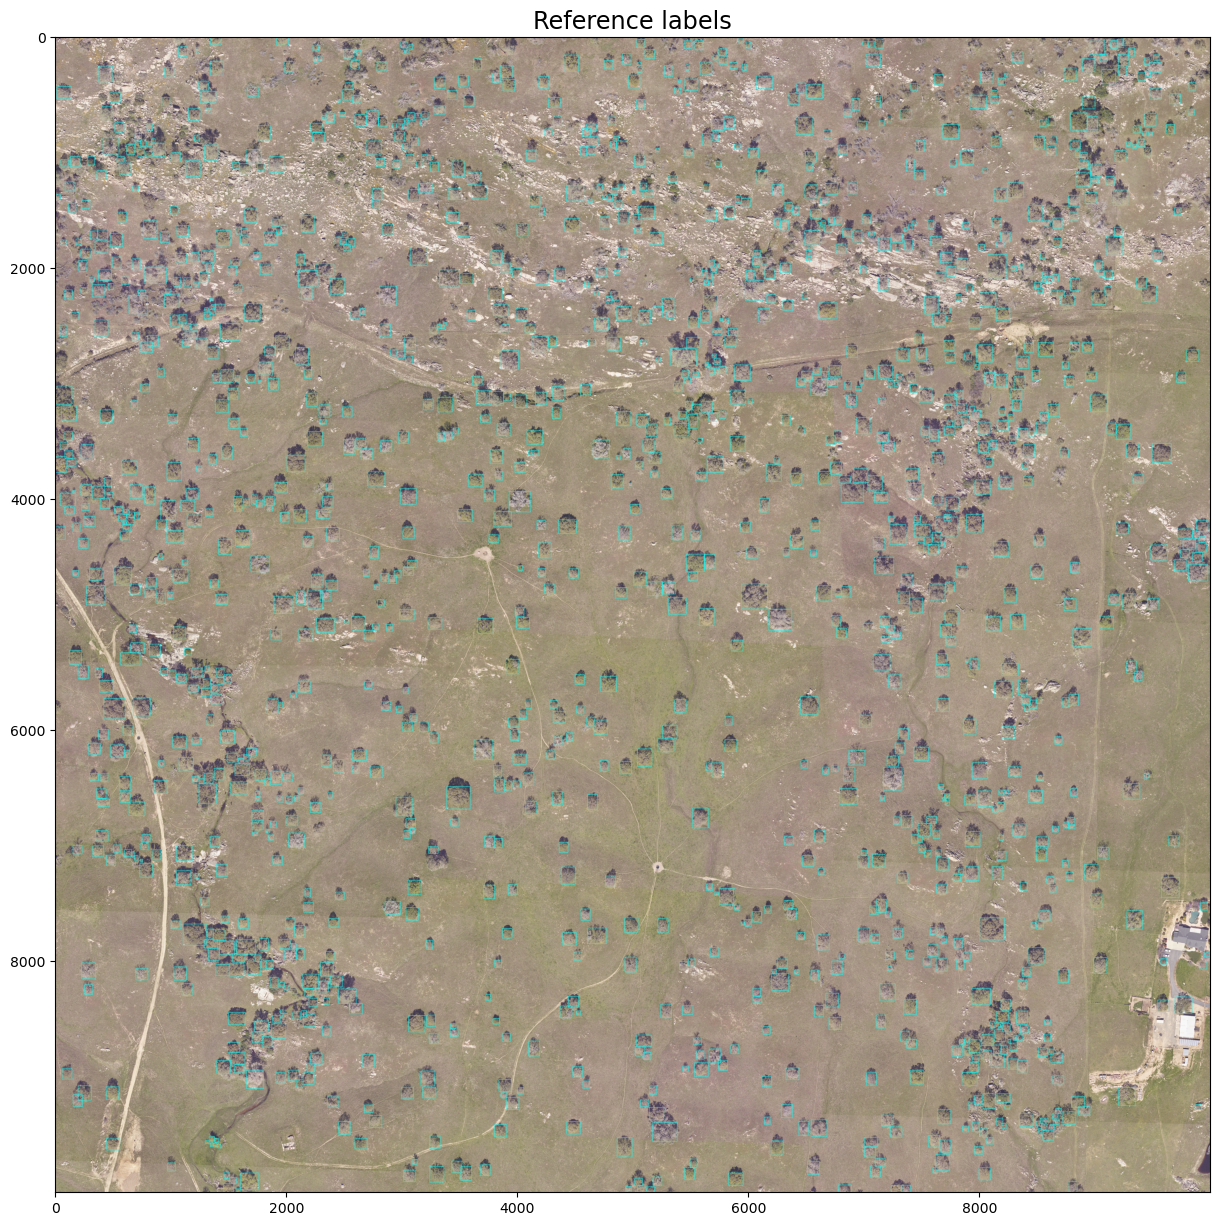

In [12]:
for row in target_bbox:
    cv2.rectangle(image2, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0,255,255), thickness=2, lineType=cv2.LINE_AA)

plot_reference = plt.figure(figsize=(15,15))
cv2_imshow(np.flip(image2,2))
plt.title('Reference labels',fontsize='xx-large')
plt.show()

### Large dense canopies

In [ ]:
pooch.retrieve(
    # url="doi:10.5281/zenodo.3459803/2018_SJER_3_258000_4106000_image.tif",
    # known_hash="md5:01a7cf23b368ff9e006fda8fe9ca4c8c",
    path=notebook_folder,
    fname="2018_MLBS_3_541000_4140000_image_crop2.tif"
)

## Load data/model
*Load full dataset or model from original or mirror sources. If the license of the dataset/model permits, we suggest creating sample data (preprocessed) or model mirror for the notebook stored in a data repository e.g. Zenodo.*

In [ ]:
from deepforest.model import CropModel

model = CropModel()

## Visualisation
*Create a visual narrative of the dataset! We suggest exploring libraries suited for interactive plotting e.g. python (Holoviews, Panel, Bokeh).*

## Summary
*Provide 3-5 bullet points summarising the main aspects of the dataset and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information
**Dataset**: Type here details of dataset(s) version.

**Codebase**: Type here details of codebase version (only for notebooks categorised under modelling/preprocesing/post-processing themes).

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [ ]:
from datetime import date
print(f'Last tested: {date.today()}')